In [ ]:
pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.6 MB/s eta 0:00:00


# Quantum GANs

In this final part of the project, we will use Quantum GANs (Generative adversarial networks) to generate handwritten digits of zero.

# Generative Adversarial Networks (GANs)
GANs are a powerful class of neural networks that are used for unsupervised learning. They are made up of two neural networks, a discriminator and a generator and use adversarial training to produce artificial data that is identical to actual data.

*   The job of the generator is to create fake data which imitates the real training dataset. On the otherhand, the discriminator acts like a detective trying to discern real from fake data. During the training process, both these neural networks iteratively improve with one another.
*   The equilibrium is when the generator is generating perfect fakes that look as if they came directly from the training data, and the discriminator is left to always guess at 50% confidence that the generator output is real or fake



## The Value Function
The training dataset represents samples drawn from some unknown data distribution $P_{data}$, and the generator has the job of trying to capture this distribution. The generator, G, starts from some initial latent distribution, $P_z$, and maps it to $P_g$ = $G(P_z$).
In practice, the two networks are trained iteratively, each with a separate loss function to be minimised as shown below:  
$\begin{equation}
L_D = -[y \cdot log(D(x)) + (1-y) \cdot log(1-D(G(z)))]
\end{equation}$

$\begin{equation}
L_G = -[(1-y) \cdot log(D(G(z)))]
\end{equation}$

# Quantum GANs: The Patch Method
Now coming onto the quantum part, in this notebook, I have tried to recreate one of the quantum GAN methods presented by Huang et al., the patch method.

### How it works?
On a top level, we basically use several **quantum generators** with each subgenerator responsible for constructing a small patch of the final image. The final image is then contructed by concatenting all of the patches together.

The **discriminator**, on the other hand, is a classical one i.e, a fully connected neural network with two hidden layers. A single output is obtained from it to represent the probability of an input being classified as real. Let's now look at the code to understand this in more detail.

Importing the necessary libraries including pennylane and pytorch to help us with quantum and classical machine learning frameworks

In [ ]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Creating a custom dataloader for our dataset of handwritten zeros

In [ ]:
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, csv_file, label=0, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.csv_file)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, 0

Creating the dataloader instance

In [ ]:
image_size = 8  # Height / width of the square images
batch_size = 1

transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset(csv_file="/content/drive/MyDrive/optical+recognition+of+handwritten+digits/optdigits.tra", transform=transform)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

Some example images

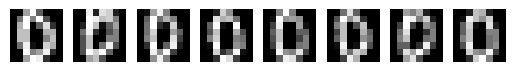

In [ ]:
for i in range(8):
    image = dataset[i][0].reshape(image_size,image_size)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()

# The Discriminator
As mentioned previously, the discriminator is a classical one with no quantum mechanics involved. It is a fully connected neural network with two hidden layers giving a single output to represent the probability of an input being classified as real.


In [ ]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(image_size * image_size, 64),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(64, 16),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

# The Quantum Generator
The overall quantum generator consists of $N_G$ sub-generators (with the same architecture), each consisting of N qubits. The process from latent vector input to image output can be split into four distinct sections: state embedding, parameterisation, non-linear transformation, and post-processing.

**1.   State embedding:**
A latent vector, $z\in \mathbb{R}^n$, is sampled from a uniform distribution in the interval $[0,\pi/2)$. All sub-generators receive the same latent vector which is then embedded using RY gates.

**2.   Parameterised Layers:**
The parameterised layer consists of parameterised RY gates followed by controlled Z gates. This layer is repeated D times in total.

**3.   Non-Linear Transform:**
Quantum gates in the circuit model are unitary which, by definition, linearly transform the quantum state. A linear mapping between the latent and generator distribution would suffice for only the most simple generative tasks, hence we need non-linear transformations for which we will use ancillary qubits. Basically, when we take a partial measurement, and trace out the ancillary subsystem, The post-measurement state, is dependent on z (latent state) in both the numerator and denominator. This means the state has been non-linearly transformed.

Finally, with the remaining data qubits ($N-N_A$), we measure the probability of the post-measurement state in each computational basis state $P(j)$, to obtain the sub-generator output, $g^{(i)}$, which is given by:

$\begin{equation}
g^{(i)} = [P(0), P(1), ...., P(2^{N-N_A}-1)]
\end{equation}$

**4.   Post-processing:**
Due to the normalisation constraint of the measurment, all elements in g(i) must sum to one. This is a problem if we are to use g(i) as the pixel intensity values for our patch. To alleviate this constraint, we apply a post-processing technique to each patch,

$\begin{equation}
x^{(i)} = \frac{g^{(i)}}{max_{k}g_{k}^{(i)}}
\end{equation}$

Therefore, the final image is given by,
$\begin{equation}
x = [x^{(1)}, ...,x^{(N_G)} ]
\end{equation}$


In [ ]:
# Quantum variables
n_qubits = 5  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 4  # Number of subgenerators for the patch method / N_G

# Defining the quantum device

In [ ]:
# Quantum simulator
dev = qml.device("lightning.qubit", wires=n_qubits)  # For qubit model of quantum computation
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# The quantum circuit and measurement process

In [ ]:
@qml.qnode(dev, diff_method="parameter-shift")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)   # which are actually trained

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))

def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]   # Partial measurement and tracing out the ancillary subsystem
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven

# The quantum generator using the above quantum circuit

In [ ]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images

# Hyperparameters for the training process

In [ ]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 500  # Number of training iterations

Initializing the quantum generator and discriminator along with the loss function and optimizers



In [ ]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
results = []

# The training process

In [ ]:
while True:
    for i, (data, _) in enumerate(dataloader):

        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1

        # Show loss values
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            test_images = generator(fixed_noise).view(8,1,image_size,image_size).cpu().detach()

            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)

        if counter == num_iter:
            break
    if counter == num_iter:
        break

Iteration: 10, Discriminator Loss: 1.361, Generator Loss: 0.596
Iteration: 20, Discriminator Loss: 1.351, Generator Loss: 0.604
Iteration: 30, Discriminator Loss: 1.308, Generator Loss: 0.624
Iteration: 40, Discriminator Loss: 1.302, Generator Loss: 0.628
Iteration: 50, Discriminator Loss: 1.270, Generator Loss: 0.655
Iteration: 60, Discriminator Loss: 1.309, Generator Loss: 0.607
Iteration: 70, Discriminator Loss: 1.252, Generator Loss: 0.652
Iteration: 80, Discriminator Loss: 1.302, Generator Loss: 0.594
Iteration: 90, Discriminator Loss: 1.254, Generator Loss: 0.615
Iteration: 100, Discriminator Loss: 1.290, Generator Loss: 0.593
Iteration: 110, Discriminator Loss: 1.198, Generator Loss: 0.659
Iteration: 120, Discriminator Loss: 1.294, Generator Loss: 0.594
Iteration: 130, Discriminator Loss: 1.262, Generator Loss: 0.624
Iteration: 140, Discriminator Loss: 1.260, Generator Loss: 0.600
Iteration: 150, Discriminator Loss: 1.259, Generator Loss: 0.615
Iteration: 160, Discriminator Loss

# Evolution of the generated images

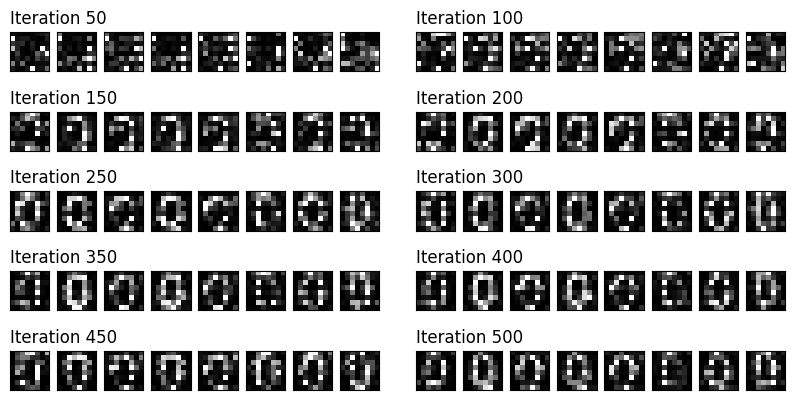

In [ ]:
fig = plt.figure(figsize=(10, 5))
outer = gridspec.GridSpec(5, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()